# Finetuning BERT, DistilBERT, MobileBERT, and TinyBERT for Fake News Classification

## Import Dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

In [4]:
df = pd.read_excel("datasets/fake_news.xlsx")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20757 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        43
label        0
dtype: int64

In [7]:
# Drop null values
df = df.dropna()
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [8]:
df.shape

(18281, 5)

In [9]:
df['label'].value_counts()

label
0    10361
1     7920
Name: count, dtype: int64

## Dataset Analysis

In [10]:
import matplotlib.pyplot as plt

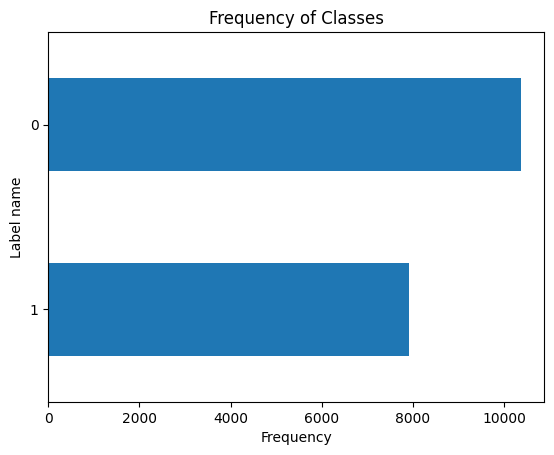

In [11]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.xlabel("Frequency")
plt.ylabel('Label name')
plt.show()

In [12]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


There are two columns that can be input for the models: title & text.

BERT models only have limited 512 token input. 

Assume every word is equal to 1.5 token. Then, find the average token length in title and text columns.

In [13]:
df['title_token'] = df['title'].apply(lambda x: (len(x.split()) * 1.5))
df['text_token'] = df['text'].apply(lambda x: (len(x.split()) * 1.5))
df.head()

,id,title,author,text,label,title_token,text_token
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,21.0,1230.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,13.5,1065.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,10.5,1899.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15.0,835.5
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,21.0,231.0


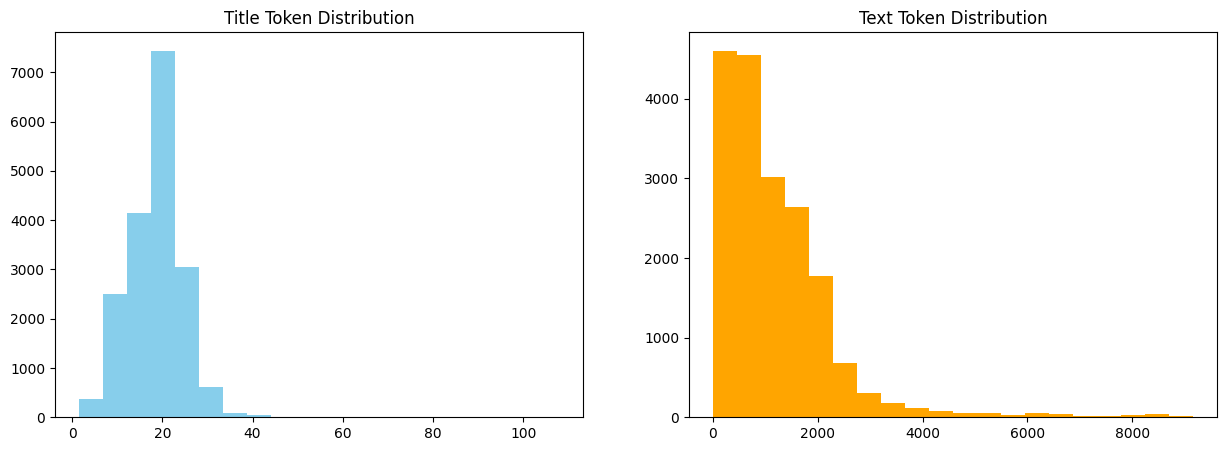

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(df['title_token'], bins=20, color='skyblue')
ax[1].hist(df['text_token'], bins=20, color='orange')

ax[0].set_title("Title Token Distribution")
ax[1].set_title("Text Token Distribution")

plt.show()

The text token has longer length so we will use the title for prediction.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
validation, test = train_test_split(test, test_size=2/3, random_state=42, stratify=test['label'])

train.shape, validation.shape, test.shape

((12796, 7), (1828, 7), (3657, 7))

In [17]:
from datasets import Dataset, DatasetDict

In [18]:
dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token'],
        num_rows: 12796
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token'],
        num_rows: 1828
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token'],
        num_rows: 3657
    })
})

In [19]:
dataset['train'][5]

{'id': 3029,
 'title': 'Fox News Poll: Clinton leads Trump by three points',
 'author': 'admin',
 'text': 'FoxNews.com October 27, 2016 \nWith less than two weeks to go, the race for the White House has narrowed as Hillary Clinton now has a three-point advantage over Donald Trump. \nThat’s within the margin of error of the national Fox News Poll of likely voters. \nClinton is ahead of Trump by 44-41 percent. Another one-in-ten back a third-party candidate and four percent are undecided. Last week she was up by six points (45-39 percent) and before that by seven (45-38 percent). \nThe poll, released Wednesday, finds Clinton leads 49-44 percent in the head-to-head matchup. That 5-point advantage is at the edge of the error margin. She was up 7 a week ago (49-42 percent). This article was posted: Thursday, October 27, 2016 at 6:33 am Share this article',
 'label': 1,
 'title_token': 13.5,
 'text_token': 192.0}

## Tokenization

In [20]:
from transformers import AutoTokenizer

In [21]:
text = "I love machine learning! Tokenization is awesome!"

model_ckpt = "distilbert/distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer(text)

In [22]:
distilbert_tokens, mobilebert_tokens, tinybert_tokens

({'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

These three tokenizers give the same results so they are basically the same.

In [23]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

tokenize(dataset['train'][:2])

{'input_ids': [[101, 6221, 8398, 22577, 4769, 28667, 9331, 102], [101, 2006, 1996, 2769, 4446, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0]]}

In [24]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 3657/3657 [00:00<00:00, 13756.79 examples/s]


In [25]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token', 'input_ids', 'attention_mask'],
        num_rows: 12796
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token', 'input_ids', 'attention_mask'],
        num_rows: 1828
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_token', 'text_token', 'input_ids', 'attention_mask'],
        num_rows: 3657
    })
})

## Model

### Model building

In [26]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig

In [27]:
label2id = {"Real": 0, "Fake": 1}
id2label = {0: "Real", 1: "Fake"}

In [28]:
model_ckpt = "distilbert/distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

num_labels = len(label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define training arguments

In [29]:
from transformers import TrainingArguments

In [30]:
batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    seed=42
)

### Define compute metrics function

In [31]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Train the model

In [32]:
from transformers import Trainer

In [33]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics_evaluate, 
                  train_dataset=dataset_encoded['train'], 
                  eval_dataset=dataset_encoded['validation'], 
                  tokenizer=distilbert_tokenizer)

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.102349,0.966630
2,0.111000,0.119743,0.963895


TrainOutput(global_step=800, training_loss=0.09141470193862915, metrics={'train_runtime': 70.2831, 'train_samples_per_second': 364.127, 'train_steps_per_second': 11.383, 'total_flos': 766787537120256.0, 'train_loss': 0.09141470193862915, 'epoch': 2.0})

### Model evaluation

In [36]:
preds_output = trainer.predict(dataset_encoded['test'])
preds_output.metrics

{'test_loss': 0.12080024927854538,
 'test_accuracy': 0.9595296691277003,
 'test_runtime': 2.6743,
 'test_samples_per_second': 1367.453,
 'test_steps_per_second': 43.002}

In [37]:
preds_output

PredictionOutput(predictions=array([[-1.6946921,  1.6345402],
       [ 3.9540267, -3.780521 ],
       [-2.8567119,  3.0684023],
       ...,
       [ 3.3152168, -3.3889124],
       [-2.6055603,  2.7708142],
       [ 3.9490893, -3.77614  ]], shape=(3657, 2), dtype=float32), label_ids=array([1, 0, 1, ..., 0, 1, 0], shape=(3657,)), metrics={'test_loss': 0.12080024927854538, 'test_accuracy': 0.9595296691277003, 'test_runtime': 2.6743, 'test_samples_per_second': 1367.453, 'test_steps_per_second': 43.002})

In [38]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = dataset_encoded['test'][:]['label']
y_true[:5]

[1, 0, 1, 1, 1]

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2073
           1       0.96      0.95      0.95      1584

    accuracy                           0.96      3657
   macro avg       0.96      0.96      0.96      3657
weighted avg       0.96      0.96      0.96      3657



### Benchmarking

In [40]:
def train_model(model_name, model_ckpt):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    def tokenize_local(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True, max_length=512)
        return temp
        
    dataset_encoded = dataset.map(tokenize_local, batched=True, batch_size=None)
    
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics_evaluate, 
                  train_dataset=dataset_encoded['train'], 
                  eval_dataset=dataset_encoded['validation'], 
                  tokenizer=distilbert_tokenizer)

    trainer.train()
    preds_output = trainer.predict(dataset_encoded['test'])
    trainer.save_model(f"fake_news_{model_name}")
    return preds_output.metrics

In [41]:
import time

In [42]:
model_dict = {
    "BERT": "bert-base-uncased",
    "DistilBERT": "distilbert/distilbert-base-uncased",
    "MobileBERT": "google/mobilebert-uncased",
    "TinyBERT": "huawei-noah/TinyBERT_General_4L_312D"
}

model_performance = {}
for model_name in model_dict:
    start_time = time.time()
    result = train_model(model_name, model_dict[model_name])
    end_time = time.time()
    result = {key: value for key, value in result.items() if key in ['test_loss', 'test_accuracy', 'test_runtime']}
    result['train_runtime'] = end_time - start_time
    model_performance[model_name] = result

Map: 100%|██████████| 3657/3657 [00:00<00:00, 6384.10 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.129426,0.950219
2,0.165200,0.135106,0.959519


Map: 100%|██████████| 3657/3657 [00:00<00:00, 14179.64 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.114794,0.961160
2,0.171100,0.118027,0.961707


Map: 100%|██████████| 3657/3657 [00:00<00:00, 11709.28 examples/s]
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3806.122070,0.772976
2,9178.143000,195.401733,0.874179


Map: 100%|██████████| 3657/3657 [00:00<00:00, 11894.98 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192904,0.923961
2,0.281200,0.158039,0.939825


In [44]:
pd.DataFrame.from_dict(model_performance)

,BERT,DistilBERT,MobileBERT,TinyBERT
test_loss,0.126215,0.116477,163.919830,0.169033
test_accuracy,0.959530,0.957069,0.868198,0.933826
test_runtime,5.230100,2.736100,4.513200,1.181300
train_runtime,149.811478,79.482980,170.509562,42.192666


The theory in the papers are proven from the results above. DistilBERT and TinyBERT achieve similar accuracy compared to BERT while the train and test runtime are faster. The only anomaly is the MobileBERT where it achieves significantly low accuracy and longer time.

### Predict with test data

In [48]:
dataset['test'][:5]['title']

['Anthony Weiner rides through sex addiction rehab on a horse',
 'In Major League Soccer, Argentines Find a Home and Success - The New York Times',
 'MIND-BLOWING LIVE Facebook POLL comments show Trump winning 95%! (90k comments+) … This is PROOF we need if election is rigged.',
 "If You Think No Other Politician Talked like Trump, Here are Other 'Donald Trumps' from America's Past",
 'Desecrating the Koran? Police Arrest 9-Year-Old Christian Boy, Torture Him for Days and Attempt to put Him on Death Row']

In [49]:
from transformers import pipeline

classifier = pipeline('text-classification', model='models/fake_news_DistilBERT')

classifier(dataset['test'][:5]['title'])

Device set to use cuda:0


[{'label': 'Fake', 'score': 0.8194633722305298},
 {'label': 'Real', 'score': 0.9992423057556152},
 {'label': 'Fake', 'score': 0.9958934783935547},
 {'label': 'Fake', 'score': 0.9955148100852966},
 {'label': 'Fake', 'score': 0.9918187856674194}]